# Editor Activation



In [1]:
library(tidyverse)
library(broom)

# library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)
library(bayesplot)

library(lme4)
library(yardstick) # install.packages("yardstick")

library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


This is bayesplot version 1.7.2

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


For binary classification, the first factor level is assumed to be the event.
Use the 

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

# Helper functions

In [3]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC <- function(mod, val_data, col_name) {
    val_data$estimate = predict(mod, val_data, type = "response")
    roc_curve(val_data, {{ col_name }}, estimate, event_level = 'second') %>%
        ggplot(aes(x = 1 - specificity, y = sensitivity)) +
        geom_path() +
        geom_abline(lty = 3) +
        coord_equal() +
        theme_bw()
}

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = user_dataset_column_types) %>%
    mutate(
        Group = factor(hp_enabled, levels = c(0, 1), labels = c("C", "HP")),
        platform = factor(reg_on_mobile == 1, c(FALSE, TRUE), c("desktop", "mobile")),
        ## Registration month, for later joins on month
        reg_month = floor_date(user_registration_timestamp, unit = 'month'),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
## Function that takes in the filename of the active editors dataset,
## and adds a registration month column for easy joining with the user dataset.
read_active_editors_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = active_editors_column_types) %>%
    mutate(wiki_db = factor(wiki_db),
           reg_month = month + months(1))
}

# Experiment Configuration Variables

We define a set of configuration variables that are useful for the analysis. One obvious one is where the edit dataset is located.

A less obvious one is a variable for when the experiment started. We often use this seeking to model the community's initial response to changes in newcomer behaviour, as well as long-term trends in the outcome variable when working with user data gathered across a relatively long time period.

In [6]:
## Path to the datasets with user edits
user_dataset_filenames <- c(
    '/home/nettrom/src/2021-Growth-structured-tasks/datasets/add-a-link-edit-data.tsv'
    )

## Column types in the dataset: wiki is a factor, HP variant is a factor, registration is a date time,
## everything else are integers.
user_dataset_column_types <- 'fiTiifiiiiiiii'

## Path to the dataset with counts of the number of active editors
active_editors_filenames <- c(
    '/home/nettrom/src/Growth-homepage-2019/datasets/newtea_revisited_feb2021_active_editor_counts.tsv',
    '/home/nettrom/src/Growth-homepage-2019/datasets/newtea_revisited_mar2021_active_editor_counts.tsv',
    '/home/nettrom/src/Growth-homepage-2019/datasets/newtea_revisited_apr2021_active_editor_counts.tsv'
    )

## Column types in the active editors dataset: month is a date, wiki is a factor
active_editors_column_types <- 'Dfiii'

## Deployment timestamps for Add a Link on each of the wikis
## Note that we turn wiki_db into a factor, otherwise wiki_db in the edit dataset
## becomes a character after joining the two.
exp_start_timestamps <- tribble(
    ~wiki_db, ~exp_start_timestamp,
    'arwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'bnwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'cswiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'viwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'fawiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'frwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'huwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'plwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'rowiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'ruwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),

) %>% mutate(wiki_db = factor(wiki_db))

## Path to the dataset with editing status at account registration
editing_status_filenames <- c()

## Column types in the editing status dataset: wiki is a factor, everything else are integers
editing_status_column_types <- 'fii'

## Path to the dataset with Welcome Survey responses
survey_response_filenames <- c()

## Columns types in the survey response data: user ID is an integer, number of languages is a number,
## everything else are factors
survey_response_column_types <- 'fifffn'

# Data import and setup

In [7]:
user_edit_data <- map_dfr(user_dataset_filenames, read_user_dataset)

In [8]:
nrow(user_edit_data)

[1] 130179

## Time since experiment start

Join the edits data with the experiment timestamps and measure time since the start to enable controlling for that:

In [9]:
user_edit_data <- user_edit_data %>%
    inner_join(exp_start_timestamps, by = 'wiki_db') %>%
    mutate(
        # Time as a measurement since deployment
        exp_days = difftime(user_registration_timestamp, exp_start_timestamp, units = 'days'),
        ln_exp_days = ifelse(exp_days < 0, 0, log(1 + as.numeric(exp_days))),
        ln_exp_weeks = ifelse(exp_days < 0, 0, log(1 + as.numeric(exp_days)/7))
    )

In [10]:
nrow(user_edit_data)

[1] 130179

Made sure that we're not dropping any users at this stage, we're good to move forward.

## Additional variables

We've previously focused on Control vs Growth Features in our analysis. In this case we'll focus primarily on Unstructured Link Task vs Add a Link, but also check against the control group. This means we want the single variable `Group` to reflect one of three options depending on `hp_enabled` and `hp_variant`

In [11]:
user_edit_data <- user_edit_data %>%
    mutate(Group = factor(ifelse(
        hp_enabled == 0, 'Control',
        ifelse(hp_variant == 'control', 'Unstructured', 'Add-a-link')),
                          c('Control', 'Unstructured', 'Add-a-link')))

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [12]:
user_edit_data %>%
    group_by(wiki_db, Group) %>%
    summarize(n = n())

`summarise()` regrouping output by 'wiki_db' (override with `.groups` argument)



wiki_db,Group,n
<fct>,<fct>,<int>
arwiki,Control,7698
arwiki,Unstructured,13426
arwiki,Add-a-link,13213
bnwiki,Control,1583
bnwiki,Unstructured,2664
bnwiki,Add-a-link,2679
cswiki,Control,787
cswiki,Unstructured,1419
cswiki,Add-a-link,1447


## Splitting into Training, Test, and Validation Datasets

Split the dataset into training, test, and validation data sets.

In [13]:
## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

trainIndex <- caret::createDataPartition(user_edit_data$Group,
                                         p = .8,
                                         list = FALSE,
                                         times = 1)
user_data_train = user_edit_data[trainIndex,]
user_data_second = user_edit_data[-trainIndex,]

testIndex = caret::createDataPartition(user_data_second$Group, p = .5, list = FALSE, times = 1)

user_data_test = user_data_second[testIndex,]
user_data_validate = user_data_second[-testIndex,]

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [14]:
user_data_test$is_activated_fct <- factor(user_data_test$is_activated,
                                          labels = c('No', 'Yes'))
user_data_validate$is_activated_fct <- factor(user_data_validate$is_activated,
                                          labels = c('No', 'Yes'))

## Visualizing Activation and Retention

We'll plot bar charts for activation and retention for the Control, Unstructured, and Add-a-link groups, split by platform.

### Activation

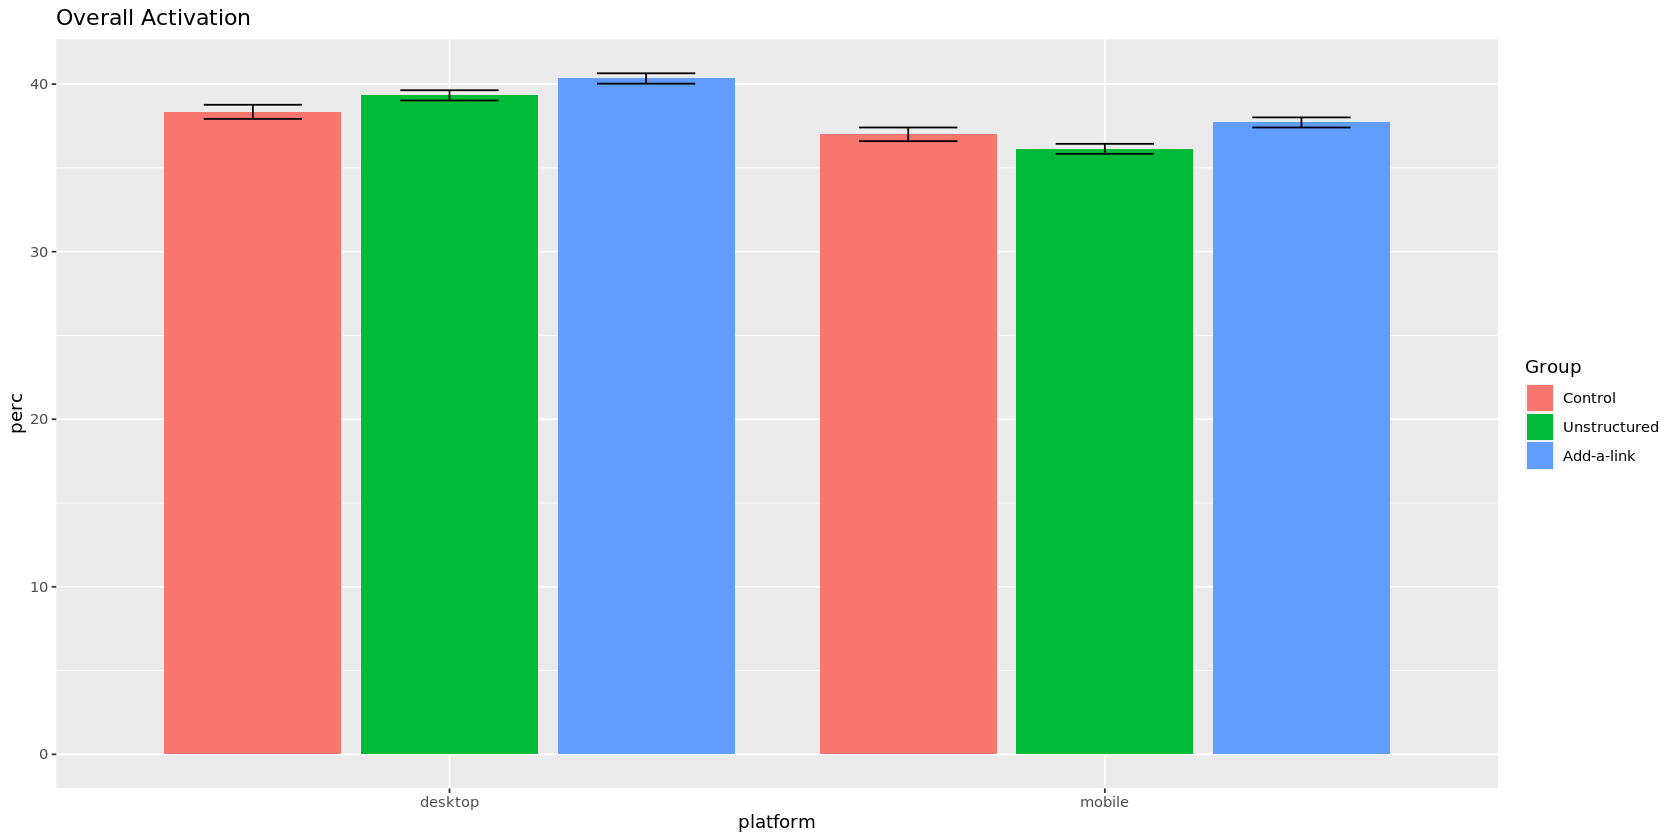

In [43]:
user_edit_data %>%
    group_by(platform, Group, is_activated) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_activated == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = Group)) +
        labs(title = 'Overall Activation') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

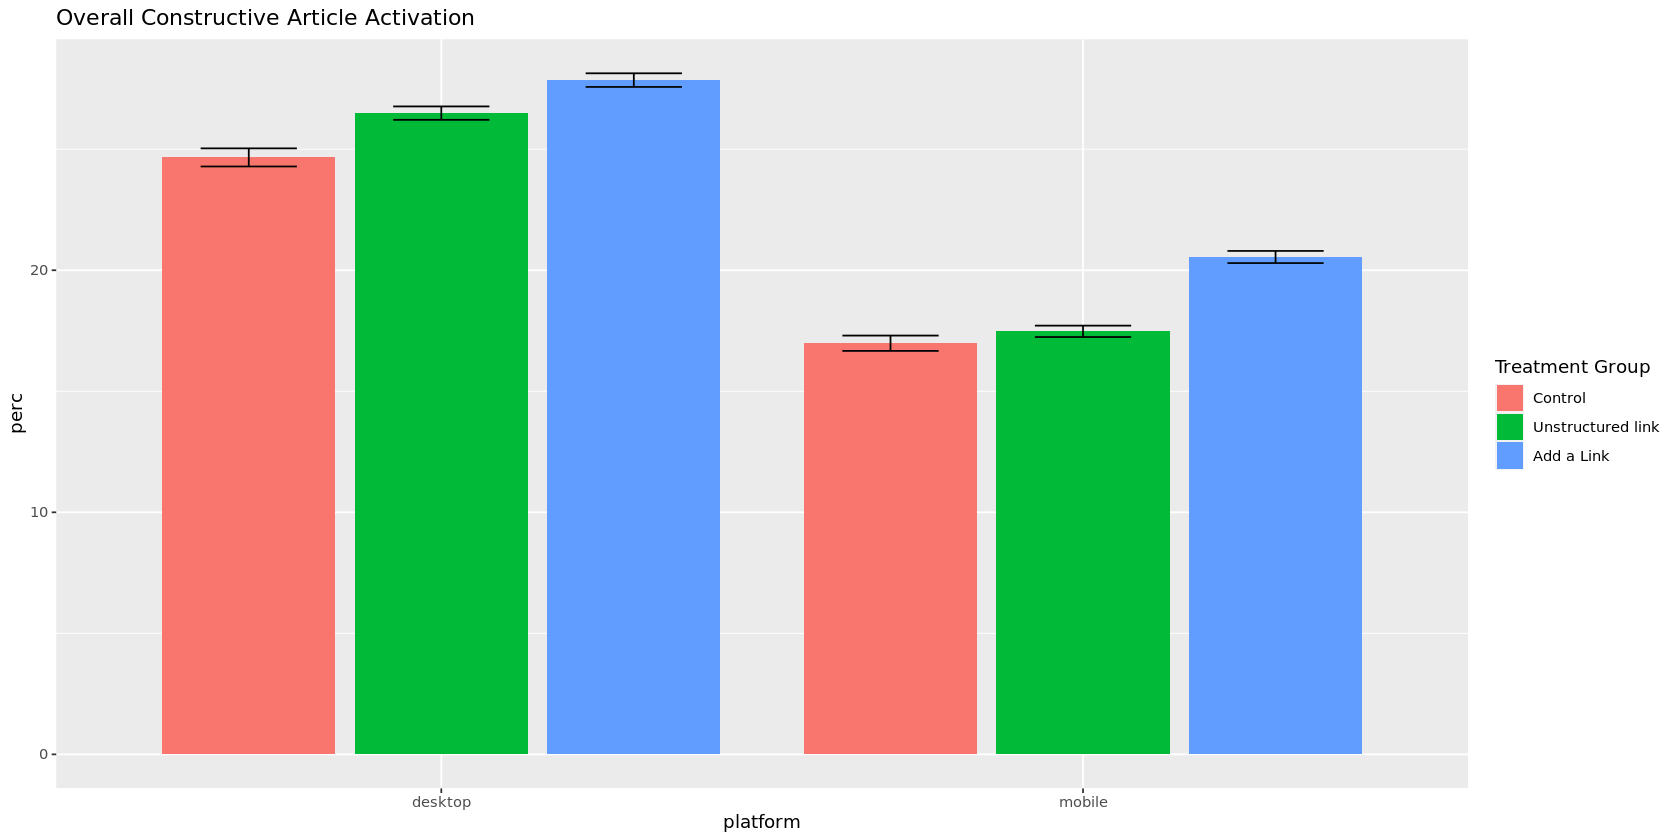

In [44]:
user_edit_data %>%
    group_by(platform, Group, is_const_activated_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_activated_article == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = Group)) +
        labs(title = 'Overall Constructive Article Activation') +
        scale_fill_discrete(name = "Treatment Group",
                            breaks = c("Control", "Unstructured", "Add-a-link"),
                            labels = c("Control", "Unstructured link", "Add a Link")) +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

# Fitting Models

## Activation

In [51]:
blas_set_num_threads(16)
activation.overall.1 <-
    glmer(
        formula = is_activated ~ platform + Group + (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [52]:
summary(activation.overall.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated ~ platform + Group + (1 | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
  137219   137266   -68604   137209   104140 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.992 -0.801 -0.704  1.169  1.574 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0699   0.264   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value     Pr(>|z|)    
(Intercept)       -0.40363    0.08465   -4.77 0.0000018592 ***
platformmobile    -0.08181    0.01353   -6.05 0.0000000015 ***
GroupUnstructured -0.00967    0.01738   -0.56        0.578    
GroupAdd-a-link    0.04766    0.01735    2.75        0.006 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) pltfrm GrpUns
platformm

This model reflects the previous graph in that Add a Link increases activation relative to the Control. It looks like in this dataset, the unstructured task might not have significantly higher activation.

Let's check for interaction between `platform` and `Group`:

In [47]:
blas_set_num_threads(16)
activation.overall.2 <-
    glmer(
        formula = is_activated ~ platform * Group + (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [48]:
summary(activation.overall.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated ~ platform * Group + (1 | wiki_db)
   Data: .

     AIC      BIC   logLik deviance df.resid 
  137218   137285   -68602   137204   104138 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.988 -0.804 -0.698  1.159  1.588 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.07     0.265   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                                 Estimate Std. Error z value   Pr(>|z|)    
(Intercept)                       -0.4205     0.0848   -4.96 0.00000071 ***
platformmobile                    -0.0485     0.0283   -1.71      0.087 .  
GroupUnstructured                  0.0243     0.0245    0.99      0.323    
GroupAdd-a-link                    0.0561     0.0245    2.29      0.022 *  
platformmobile:GroupUnstructured  -0.0678     0.0346   -1.96      0.050 .  
platformmobil

We don't find conclusive evidence of interaction. The BIC is much worse, suggesting that the complexity in the model isn't warranted. We see a marginally significant interaction on mobile for the unstructured task. Given these findings, we discard this model and check for wiki-level variation in `platform` and `Group`.

In [53]:
blas_set_num_threads(16)
activation.overall.3 <-
    glmer(
        formula = is_activated ~ platform + Group + (1 + platform | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [54]:
summary(activation.overall.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated ~ platform + Group + (1 + platform | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
  137025   137092   -68505   137011   104138 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.996 -0.772 -0.697  1.110  1.641 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.0691   0.263         
         platformmobile 0.0343   0.185    -0.15
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value   Pr(>|z|)    
(Intercept)       -0.40763    0.08282   -4.92 0.00000086 ***
platformmobile    -0.10300    0.06157   -1.67      0.094 .  
GroupUnstructured -0.00955    0.01737   -0.55      0.582    
GroupAdd-a-link    0.04762    0.01734    2.75      0.006 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Corre

This model indicates a meaningful difference in the effect of `platform` on the wiki level. We've seen this in multiple previous analyses, so it comes as no surprise.

In [55]:
blas_set_num_threads(16)
activation.overall.4 <-
    glmer(
        formula = is_activated ~ platform + Group + (1 + platform + Group | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see ?isSingular



This model is singular, so we discard it. No indication of a meaningful variation between wikis when it comes to the effect of `Group`

In [57]:
blas_set_num_threads(16)
activation.article.1 <-
    glmer(
        formula = is_activated_article ~ platform + Group + (1 + platform | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [58]:
summary(activation.article.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated_article ~ platform + Group + (1 + platform | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
  122850   122916   -61418   122836   104138 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.851 -0.660 -0.539  1.253  2.186 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.1297   0.360         
         platformmobile 0.0551   0.235    -0.36
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value         Pr(>|z|)    
(Intercept)        -0.8443     0.1147   -7.36 0.00000000000018 ***
platformmobile     -0.1525     0.0777   -1.96           0.0496 *  
GroupUnstructured   0.0502     0.0189    2.66           0.0079 ** 
GroupAdd-a-link     0.1341     0.0188    7.13 0.00000000000103 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘

In [59]:
blas_set_num_threads(16)
activation.article.2 <-
    glmer(
        formula = is_activated_article ~ platform * Group + (1 + platform | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [60]:
summary(activation.article.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated_article ~ platform * Group + (1 + platform | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
  122847   122933   -61414   122829   104136 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.843 -0.667 -0.534  1.240  2.180 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.1297   0.360         
         platformmobile 0.0552   0.235    -0.36
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                                 Estimate Std. Error z value         Pr(>|z|)
(Intercept)                       -0.8496     0.1152   -7.38 0.00000000000016
platformmobile                    -0.1416     0.0811   -1.75           0.0810
GroupUnstructured                  0.0761     0.0261    2.91           0.0036
GroupAdd-a-link                    0.1215     0.0261    4.

No indication of an interaction effect here.

In [61]:
blas_set_num_threads(16)
activation.article.3 <-
    glmer(
        formula = is_activated_article ~ platform + Group + (1 + platform + Group | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see ?isSingular



This model is also singular, so we discard it.

In [ ]:
blas_set_num_threads(16)
activation.overall.constr.1 <-
    glmer(
        formula = is_const_activated ~ platform + Group + (1 + platform | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [68]:
summary(activation.overall.constr.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated ~ platform + Group + (1 + platform | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
  129184   129251   -64585   129170   104138 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.872 -0.713 -0.616  1.256  1.974 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.0550   0.235         
         platformmobile 0.0202   0.142    -0.20
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value             Pr(>|z|)    
(Intercept)        -0.6245     0.0750   -8.32 < 0.0000000000000002 ***
platformmobile     -0.2452     0.0498   -4.92           0.00000086 ***
GroupUnstructured  -0.0111     0.0182   -0.61                 0.54    
GroupAdd-a-link     0.0710     0.0181    3.93           0.00008501 ***
---
Signif. codes

In [69]:
blas_set_num_threads(16)
activation.overall.constr.2 <-
    glmer(
        formula = is_const_activated ~ platform * Group + (1 + platform | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [70]:
summary(activation.overall.constr.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated ~ platform * Group + (1 + platform | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
  129181   129267   -64581   129163   104136 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.863 -0.715 -0.609  1.256  1.997 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.0550   0.235         
         platformmobile 0.0202   0.142    -0.20
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                                 Estimate Std. Error z value           Pr(>|z|)
(Intercept)                      -0.62504    0.07829   -7.98 0.0000000000000014
platformmobile                   -0.24442    0.05648   -4.33 0.0000150742889595
GroupUnstructured                 0.00956    0.02538    0.38              0.706
GroupAdd-a-link                   0.05139    0.02539

No indication of interaction here either.

In [71]:
blas_set_num_threads(16)
activation.overall.constr.3 <-
    glmer(
        formula = is_const_activated ~ platform + Group + (1 + platform + Group | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see ?isSingular



This model is also singular and hence we discard it too.

In [63]:
blas_set_num_threads(16)
activation.article.constr.1 <-
    glmer(
        formula = is_const_activated_article ~ platform + Group + (1 + platform | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [64]:
summary(activation.article.constr.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ platform + Group + (1 + platform |  
    wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
  108338   108404   -54162   108324   104138 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.760 -0.600 -0.465 -0.382  2.620 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.1075   0.328         
         platformmobile 0.0367   0.192    -0.45
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value             Pr(>|z|)    
(Intercept)        -1.1042     0.1014  -10.89 < 0.0000000000000002 ***
platformmobile     -0.3672     0.0637   -5.77          0.000000008 ***
GroupUnstructured   0.0492     0.0207    2.38                0.018 *  
GroupAdd-a-link     0.1802     0.0205    8.80 < 0.0000000000000002 ***
---

In [73]:
blas_set_num_threads(16)
activation.article.constr.2 <-
    glmer(
        formula = is_const_activated_article ~ platform * Group + (1 + platform | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [74]:
summary(activation.article.constr.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ platform * Group + (1 + platform |  
    wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
  108322   108408   -54152   108304   104136 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.747 -0.609 -0.472 -0.378  2.649 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.1076   0.328         
         platformmobile 0.0369   0.192    -0.45
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                                 Estimate Std. Error z value
(Intercept)                       -1.0871     0.1056  -10.29
platformmobile                    -0.4065     0.0703   -5.78
GroupUnstructured                  0.0601     0.0275    2.19
GroupAdd-a-link                    0.1271     0.0273    4.65
platformmobile:GroupUnstructured  -0.0255     0.0415 

In [75]:
blas_set_num_threads(16)
activation.article.constr.3 <-
    glmer(
        formula = is_const_activated_article ~ platform + Group + (1 + platform + Group | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see ?isSingular



This model is also singular, so we discard it as well.

## Models on the Full Dataset

### Overall Activation

In [76]:
blas_set_num_threads(16)
activation.overall.full <-
    glmer(
        formula = is_activated ~ platform + Group + (1 + platform | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [78]:
summary(activation.overall.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated ~ platform + Group + (1 + platform | wiki_db)
   Data: user_edit_data

     AIC      BIC   logLik deviance df.resid 
  171328   171396   -85657   171314   130172 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.006 -0.767 -0.694  1.112  1.641 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.0711   0.267         
         platformmobile 0.0362   0.190    -0.17
Number of obs: 130179, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value  Pr(>|z|)    
(Intercept)        -0.4084     0.0838   -4.87 0.0000011 ***
platformmobile     -0.0859     0.0621   -1.38    0.1668    
GroupUnstructured  -0.0106     0.0155   -0.68    0.4963    
GroupAdd-a-link     0.0443     0.0155    2.86    0.0043 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation

In [91]:
blas_set_num_threads(16)
activation.overall.growth <-
    user_edit_data %>%
    filter(Group != "Control") %>%
    glmer(
        formula = is_activated ~ platform + Group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [92]:
summary(activation.overall.growth)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated ~ platform + Group + (1 + platform | wiki_db)
   Data: .

     AIC      BIC   logLik deviance df.resid 
  135479   135537   -67734   135467   102837 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.018 -0.769 -0.692  1.101  1.620 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.0746   0.273         
         platformmobile 0.0347   0.186    -0.21
Number of obs: 102843, groups:  wiki_db, 10

Fixed effects:
                Estimate Std. Error z value  Pr(>|z|)    
(Intercept)      -0.4152     0.0869   -4.78 0.0000018 ***
platformmobile   -0.1007     0.0621   -1.62       0.1    
GroupAdd-a-link   0.0549     0.0129    4.25 0.0000213 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) pltfrm
platformmbl -0.226       
GrpAdd--ln

In [105]:
# Aggregate across the entire dataset the proportion of registrations activating
activation.overall.agg <- user_edit_data %>%
    group_by(Group, is_activated) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
activation.overall.agg

Group,is_activated,n,perc,rounded_perc
<fct>,<lgl>,<int>,<dbl>,<dbl>
Control,FALSE,17042,62.3,62.3
Control,TRUE,10294,37.7,37.7
Unstructured,FALSE,32060,62.3,62.3
Unstructured,TRUE,19419,37.7,37.7
Add-a-link,FALSE,31327,61.0,61.0
Add-a-link,TRUE,20037,39.0,39.0


In [106]:
## Calculate increase in percent
round(activation.overall.agg[4, "perc"] - activation.overall.agg[2, "perc"], 1)

perc
<dbl>
0.1


In [107]:
## Calculate increase in percent
round(100 * (activation.overall.agg[4, "perc"] - activation.overall.agg[2, "perc"]) /
        activation.overall.agg[2,"perc"], 1)

perc
<dbl>
0.2


In [108]:
## Calculate increase in percent
round(activation.overall.agg[6, "perc"] - activation.overall.agg[2, "perc"], 1)

perc
<dbl>
1.4


In [109]:
## Calculate increase in percent
round(100 * (activation.overall.agg[6, "perc"] - activation.overall.agg[2, "perc"]) /
        activation.overall.agg[2,"perc"], 1)

perc
<dbl>
3.6


### Overall Constructive Activation

In [93]:
blas_set_num_threads(16)
activation.overall.constr.full <-
    glmer(
        formula = is_const_activated ~ platform + Group + (1 + platform | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [94]:
summary(activation.overall.constr.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated ~ platform + Group + (1 + platform | wiki_db)
   Data: user_edit_data

     AIC      BIC   logLik deviance df.resid 
  161591   161660   -80788   161577   130172 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.885 -0.708 -0.622  1.258  1.970 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.0552   0.235         
         platformmobile 0.0274   0.166    -0.29
Number of obs: 130179, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value             Pr(>|z|)    
(Intercept)        -0.6202     0.0748   -8.29 < 0.0000000000000002 ***
platformmobile     -0.2442     0.0556   -4.39             0.000011 ***
GroupUnstructured  -0.0123     0.0162   -0.76                 0.45    
GroupAdd-a-link     0.0656     0.0162    4.06             0.000048 ***
---
Signif. codes:

In [110]:
# Aggregate across the entire dataset the proportion of registrations activating
activation.overall.constr.agg <- user_edit_data %>%
    group_by(Group, is_const_activated) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
activation.overall.constr.agg

Group,is_const_activated,n,perc,rounded_perc
<fct>,<lgl>,<int>,<dbl>,<dbl>
Control,FALSE,18758,68.6,68.6
Control,TRUE,8578,31.4,31.4
Unstructured,FALSE,35317,68.6,68.6
Unstructured,TRUE,16162,31.4,31.4
Add-a-link,FALSE,34374,66.9,66.9
Add-a-link,TRUE,16990,33.1,33.1


In [111]:
## Calculate increase in percent
round(activation.overall.constr.agg[4, "perc"] - activation.overall.constr.agg[2, "perc"], 1)

perc
<dbl>
0


In [112]:
## Calculate increase in percent
round(100 * (activation.overall.constr.agg[4, "perc"] - activation.overall.constr.agg[2, "perc"]) /
        activation.overall.constr.agg[2,"perc"], 1)

perc
<dbl>
0


In [113]:
## Calculate increase in percent
round(activation.overall.constr.agg[6, "perc"] - activation.overall.constr.agg[2, "perc"], 1)

perc
<dbl>
1.7


In [114]:
## Calculate increase in percent
round(100 * (activation.overall.constr.agg[6, "perc"] - activation.overall.constr.agg[2, "perc"]) /
        activation.overall.constr.agg[2,"perc"], 1)

perc
<dbl>
5.4


### Article and Article Talk Namespaces

In [101]:
blas_set_num_threads(16)
activation.article.full <-
    glmer(
        formula = is_activated_article ~ platform + Group + (1 + platform | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [102]:
summary(activation.article.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated_article ~ platform + Group + (1 + platform | wiki_db)
   Data: user_edit_data

     AIC      BIC   logLik deviance df.resid 
  153534   153603   -76760   153520   130172 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.855 -0.655 -0.538  1.247  2.163 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.1315   0.363         
         platformmobile 0.0597   0.244    -0.38
Number of obs: 130179, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value            Pr(>|z|)    
(Intercept)        -0.8540     0.1097   -7.79 0.00000000000000691 ***
platformmobile     -0.1353     0.0784   -1.73              0.0842 .  
GroupUnstructured   0.0535     0.0169    3.16              0.0016 ** 
GroupAdd-a-link     0.1365     0.0168    8.11 0.00000000000000049 ***
---
Signif. codes:  0

In [103]:
blas_set_num_threads(16)
activation.article.growth <-
    user_edit_data %>%
    filter(Group != "Control") %>%
    glmer(
        formula = is_activated_article ~ platform + Group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [104]:
summary(activation.article.growth)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated_article ~ platform + Group + (1 + platform | wiki_db)
   Data: .

     AIC      BIC   logLik deviance df.resid 
  122240   122297   -61114   122228   102837 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.850 -0.673 -0.540  1.249  2.115 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.1345   0.367         
         platformmobile 0.0577   0.240    -0.43
Number of obs: 102843, groups:  wiki_db, 10

Fixed effects:
                Estimate Std. Error z value         Pr(>|z|)    
(Intercept)      -0.7980     0.1118   -7.14 0.00000000000095 ***
platformmobile   -0.1520     0.0768   -1.98            0.048 *  
GroupAdd-a-link   0.0831     0.0138    6.00 0.00000000194864 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) pltfrm


In [115]:
# Aggregate across the entire dataset the proportion of registrations activating
activation.article.agg <- user_edit_data %>%
    group_by(Group, is_activated_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
activation.article.agg

Group,is_activated_article,n,perc,rounded_perc
<fct>,<lgl>,<int>,<dbl>,<dbl>
Control,FALSE,19904,72.8,72.8
Control,TRUE,7432,27.2,27.2
Unstructured,FALSE,36733,71.4,71.4
Unstructured,TRUE,14746,28.6,28.6
Add-a-link,FALSE,35772,69.6,69.6
Add-a-link,TRUE,15592,30.4,30.4


In [116]:
## Calculate increase in percent
round(activation.article.agg[4, "perc"] - activation.article.agg[2, "perc"], 1)

perc
<dbl>
1.5


In [117]:
## Calculate increase in percent
round(100 * (activation.article.agg[4, "perc"] - activation.article.agg[2, "perc"]) /
        activation.article.agg[2,"perc"], 1)

perc
<dbl>
5.4


In [118]:
## Calculate increase in percent
round(activation.article.agg[6, "perc"] - activation.article.agg[2, "perc"], 1)

perc
<dbl>
3.2


In [119]:
## Calculate increase in percent
round(100 * (activation.article.agg[6, "perc"] - activation.article.agg[2, "perc"]) /
        activation.article.agg[2,"perc"], 1)

perc
<dbl>
11.7


In [120]:
blas_set_num_threads(16)
activation.article.constr.full <-
    glmer(
        formula = is_const_activated_article ~ platform + Group + (1 + platform | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [123]:
summary(activation.article.constr.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ platform + Group + (1 + platform |  
    wiki_db)
   Data: user_edit_data

     AIC      BIC   logLik deviance df.resid 
  135434   135502   -67710   135420   130172 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.764 -0.597 -0.466 -0.383  2.611 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.1109   0.333         
         platformmobile 0.0453   0.213    -0.49
Number of obs: 130179, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value             Pr(>|z|)    
(Intercept)        -1.1092     0.1011  -10.97 < 0.0000000000000002 ***
platformmobile     -0.3619     0.0683   -5.30           0.00000011 ***
GroupUnstructured   0.0527     0.0185    2.84               0.0045 ** 
GroupAdd-a-link     0.1794     0.0183    9.78 < 0.0000000000000002 ***
---


In [121]:
blas_set_num_threads(16)
activation.article.constr.full.interact <-
    glmer(
        formula = is_const_activated_article ~ platform * Group + (1 + platform | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [124]:
summary(activation.article.constr.full.interact)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ platform * Group + (1 + platform |  
    wiki_db)
   Data: user_edit_data

     AIC      BIC   logLik deviance df.resid 
  135418   135506   -67700   135400   130170 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.754 -0.606 -0.469 -0.383  2.611 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.1109   0.333         
         platformmobile 0.0454   0.213    -0.49
Number of obs: 130179, groups:  wiki_db, 10

Fixed effects:
                                 Estimate Std. Error z value
(Intercept)                       -1.1098     0.1033  -10.75
platformmobile                    -0.3609     0.0734   -4.92
GroupUnstructured                  0.0837     0.0246    3.41
GroupAdd-a-link                    0.1506     0.0245    6.15
platformmobile:GroupUnstructured  -0.0716     0.0370  

In [125]:
blas_set_num_threads(16)
activation.article.constr.growth <-
    user_edit_data %>%
    filter(Group != "Control") %>%
    glmer(
        formula = is_const_activated_article ~ platform + Group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [126]:
summary(activation.article.constr.growth)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ platform + Group + (1 + platform |  
    wiki_db)
   Data: .

     AIC      BIC   logLik deviance df.resid 
  108275   108333   -54132   108263   102837 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.761 -0.599 -0.470 -0.398  2.515 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 wiki_db (Intercept)    0.1127   0.336         
         platformmobile 0.0459   0.214    -0.53
Number of obs: 102843, groups:  wiki_db, 10

Fixed effects:
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      -1.0578     0.1018  -10.39 < 0.0000000000000002 ***
platformmobile   -0.3758     0.0704   -5.34          0.000000094 ***
GroupAdd-a-link   0.1269     0.0150    8.45 < 0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects

In [16]:
# Aggregate across the entire dataset the proportion of registrations activating
activation.article.constr.agg <- user_edit_data %>%
    group_by(Group, is_const_activated_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
activation.article.constr.agg

Group,is_const_activated_article,n,perc,rounded_perc
<fct>,<lgl>,<int>,<dbl>,<dbl>
Control,FALSE,21670,79.3,79.3
Control,TRUE,5666,20.7,20.7
Unstructured,FALSE,40178,78.0,78.0
Unstructured,TRUE,11301,22.0,22.0
Add-a-link,FALSE,38954,75.8,75.8
Add-a-link,TRUE,12410,24.2,24.2


In [128]:
## Calculate increase in percent
round(activation.article.constr.agg[4, "perc"] - activation.article.constr.agg[2, "perc"], 1)

perc
<dbl>
1.2


In [129]:
## Calculate increase in percent
round(100 * (activation.article.constr.agg[4, "perc"] - activation.article.constr.agg[2, "perc"]) /
        activation.article.constr.agg[2,"perc"], 1)

perc
<dbl>
5.9


In [130]:
## Calculate increase in percent
round(activation.article.constr.agg[6, "perc"] - activation.article.constr.agg[2, "perc"], 1)

perc
<dbl>
3.4


In [131]:
## Calculate increase in percent
round(100 * (activation.article.constr.agg[6, "perc"] - activation.article.constr.agg[2, "perc"]) /
        activation.article.constr.agg[2,"perc"], 1)

perc
<dbl>
16.6


Percentage point and relative difference between the unstructured and structured task groups:

In [18]:
## Calculate increase in percent
round(activation.article.constr.agg[6, "perc"] - activation.article.constr.agg[4, "perc"], 1)

perc
<dbl>
2.2


In [19]:
## Calculate increase in percent
round(100 * (activation.article.constr.agg[6, "perc"] - activation.article.constr.agg[4, "perc"]) /
        activation.article.constr.agg[4,"perc"], 1)

perc
<dbl>
10.1


# Graphs

## Article Activation

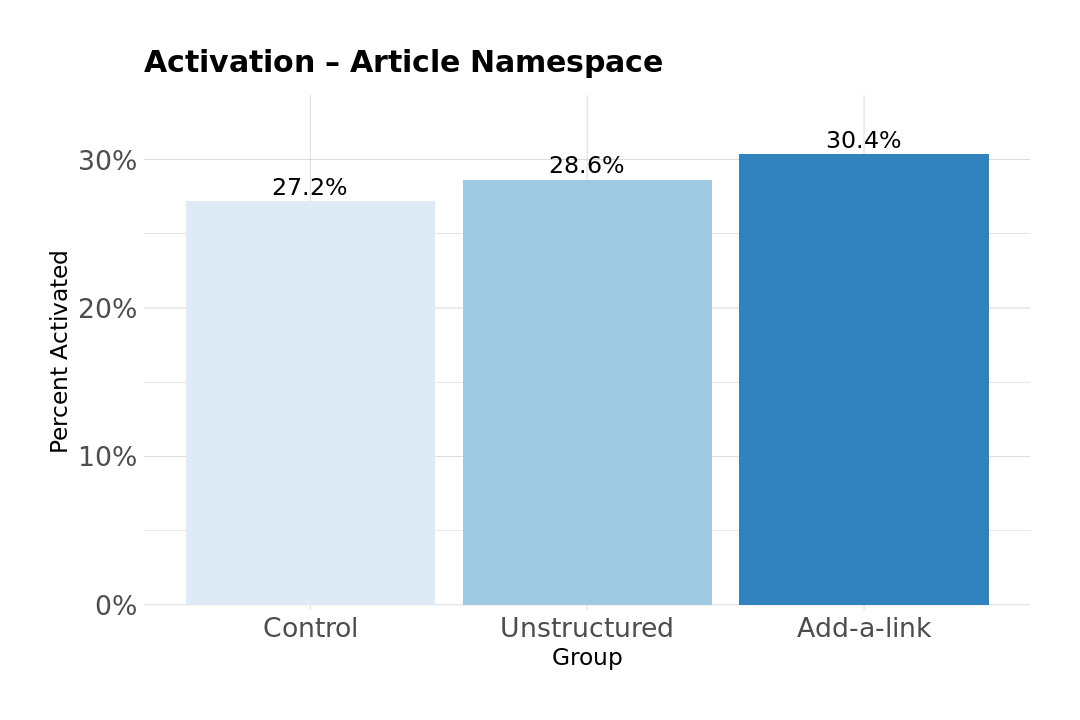

In [32]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)
user_edit_data %>%
    group_by(Group, is_activated_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group,
           group_name = ifelse(Group == 'C', 'Control', 'Treatment')) %>%
    filter(is_activated_article == TRUE) %>%
    ggplot(aes(x = Group, y = prob, fill = Group)) +
        labs(title = 'Activation – Article Namespace', x = 'Group', y = 'Percent Activated') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.34)) +
        geom_col() +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.01, size = 5)
ggsave(
    'add-a-link-article-namespace-activation-2021-experiment.png',
    path = 'graphs',
    width = 9, height = 6, units = "in", dpi = "screen")

## Constructive Article Activation

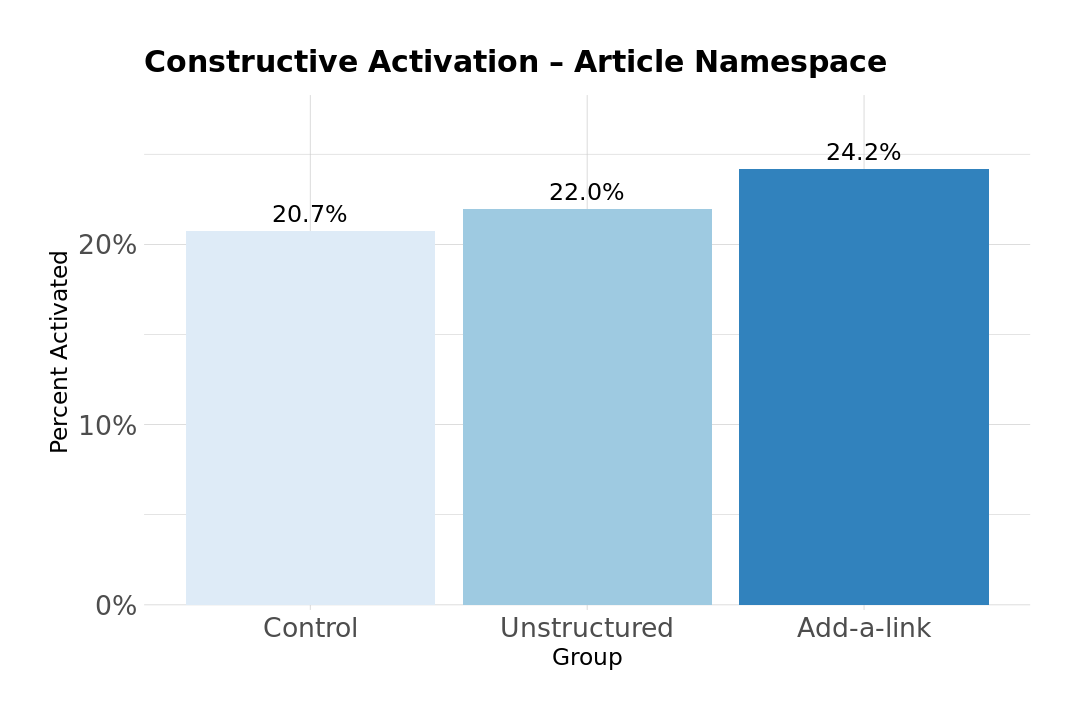

In [34]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)
user_edit_data %>%
    group_by(Group, is_const_activated_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group,
           group_name = ifelse(Group == 'C', 'Control', 'Treatment')) %>%
    filter(is_const_activated_article == TRUE) %>%
    ggplot(aes(x = Group, y = prob, fill = Group)) +
        labs(title = 'Constructive Activation – Article Namespace', x = 'Group', y = 'Percent Activated') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.28)) +
        geom_col() +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.01, size = 5)
ggsave(
    'add-a-link-article-namespace-constructive-activation-2021-experiment.png',
    path = 'graphs',
    width = 9, height = 6, units = "in", dpi = "screen")

## Users Per Group

For the report, what's the proportion of users in each group?

In [35]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)
user_edit_data %>%
    group_by(Group) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group)

Group,n,per_group,perc,prob
<fct>,<int>,<int>,<dbl>,<dbl>
Control,27336,130179,21.0,0.210
Unstructured,51479,130179,39.5,0.395
Add-a-link,51364,130179,39.5,0.395
